# Arrêt précoce de la descente de gradient stochastique

La descente de gradient stochastique (**SGD** - *Stochastic Gradient Descent*) est une technique d'optimisation qui minimise une fonction de perte de manière stochastique, en effectuant une étape de descente de gradient échantillon par échantillon. En particulier, c'est une méthode très efficace pour ajuster des modèles linéaires.

En tant que méthode stochastique, la fonction de perte n'est pas nécessairement décroissante à chaque itération, et la convergence n'est garantie qu'en espérance. Pour cette raison, le suivi de la convergence sur la fonction de perte peut être difficile.

Une autre approche consiste à surveiller la convergence sur un score de validation. Dans ce cas, les données d'entrée sont divisées en un ensemble d'apprentissage et un ensemble de validation. Le modèle est ensuite ajusté sur l'ensemble d'apprentissage et le critère d'arrêt est basé sur le score de prédiction calculé sur l'ensemble de validation. Cela nous permet de trouver le plus petit nombre d'itérations suffisant pour construire un modèle qui se généralise bien aux données indédites et réduit le risque de surajustement des données d'apprentissage.

Cette stratégie d'arrêt anticipé est activée si `early_stopping=True`; sinon le critère d'arrêt n'utilise que la perte d'apprentissage sur l'ensemble des données d'entrée. Pour mieux contrôler la stratégie d'arrêt précoce, nous pouvons spécifier un paramètre `validation_fraction` qui définit la fraction de l'ensemble de données d'entrée que nous gardons de côté pour calculer le score de validation. L'optimisation se poursuivra jusqu'à ce que le score de validation ne se soit pas amélioré d'au moins `tol` au cours des dernières itérations `n_iter_no_change`. Le nombre réel d'itérations est disponible dans l'attribut `n_iter_`.

Cet exemple illustre comment l'arrêt précoce peut être utilisé dans le modèle [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) pour obtenir presque la même précision par rapport à un modèle construit sans arrêt précoce. Cela peut réduire considérablement le temps d'apprentissage. Notez que les scores diffèrent entre les critères d'arrêt, même à partir des premières itérations, car certaines des données d'apprentissage sont conservées avec le critère d'arrêt de validation.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_sgd_early_stopping_001.png)

No stopping criterion: .................................................
Training loss: .................................................
Validation score: .................................................


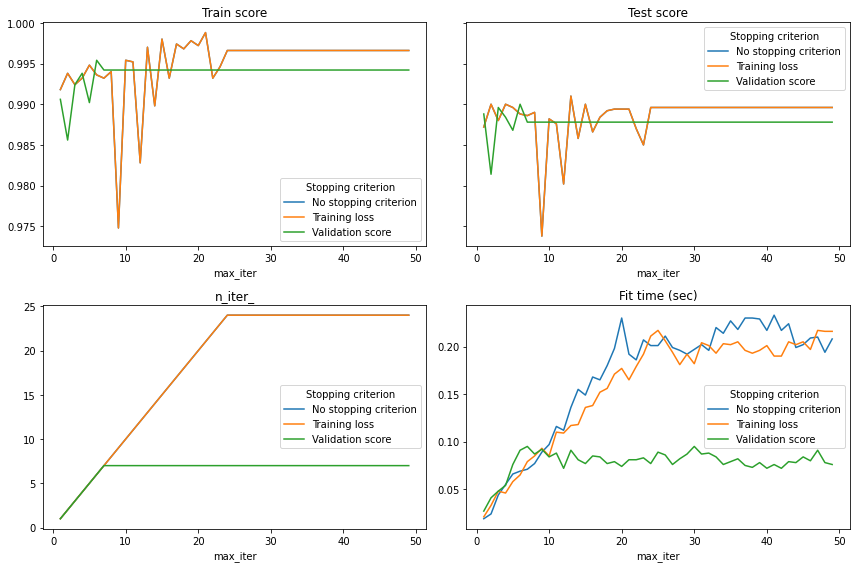

In [1]:
# Authors: Tom Dupre la Tour
#
# License: BSD 3 clause

import time
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle


def load_mnist(n_samples=None, class_0="0", class_1="8"):
    """Load MNIST, select two classes, shuffle and return only n_samples."""
    # Load data from http://openml.org/d/554
    mnist = fetch_openml("mnist_784", version=1, as_frame=False)

    # take only two classes for binary classification
    mask = np.logical_or(mnist.target == class_0, mnist.target == class_1)

    X, y = shuffle(mnist.data[mask], mnist.target[mask], random_state=42)
    if n_samples is not None:
        X, y = X[:n_samples], y[:n_samples]
    return X, y


@ignore_warnings(category=ConvergenceWarning)
def fit_and_score(estimator, max_iter, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.set_params(max_iter=max_iter)
    estimator.set_params(random_state=0)

    start = time.time()
    estimator.fit(X_train, y_train)

    fit_time = time.time() - start
    n_iter = estimator.n_iter_
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return fit_time, n_iter, train_score, test_score


# Define the estimators to compare
estimator_dict = {
    "No stopping criterion": linear_model.SGDClassifier(n_iter_no_change=3),
    "Training loss": linear_model.SGDClassifier(
        early_stopping=False, n_iter_no_change=3, tol=0.1
    ),
    "Validation score": linear_model.SGDClassifier(
        early_stopping=True, n_iter_no_change=3, tol=0.0001, validation_fraction=0.2
    ),
}

# Load the dataset
X, y = load_mnist(n_samples=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

results = []
for estimator_name, estimator in estimator_dict.items():
    print(estimator_name + ": ", end="")
    for max_iter in range(1, 50):
        print(".", end="")
        sys.stdout.flush()

        fit_time, n_iter, train_score, test_score = fit_and_score(
            estimator, max_iter, X_train, X_test, y_train, y_test
        )

        results.append(
            (estimator_name, max_iter, fit_time, n_iter, train_score, test_score)
        )
    print("")

# Transform the results in a pandas dataframe for easy plotting
columns = [
    "Stopping criterion",
    "max_iter",
    "Fit time (sec)",
    "n_iter_",
    "Train score",
    "Test score",
]
results_df = pd.DataFrame(results, columns=columns)

# Define what to plot (x_axis, y_axis)
lines = "Stopping criterion"
plot_list = [
    ("max_iter", "Train score"),
    ("max_iter", "Test score"),
    ("max_iter", "n_iter_"),
    ("max_iter", "Fit time (sec)"),
]

nrows = 2
ncols = int(np.ceil(len(plot_list) / 2.0))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1])

for ax, (x_axis, y_axis) in zip(axes.ravel(), plot_list):
    for criterion, group_df in results_df.groupby(lines):
        group_df.plot(x=x_axis, y=y_axis, label=criterion, ax=ax)
    ax.set_title(y_axis)
    ax.legend(title=lines)

fig.tight_layout()
plt.show()